<h1 style="text-align:center"> Drexel University </h1>
<h2 style = "text-align:center"> College of Computing and Informatics</h2>
<h2 style = "text-align:center">INFO 323: Cloud Computing and Big Data</h2>
<h3 style = "text-align:center">Assignment 2 Exploratory Data Analysis</h3>
<div style="text-align:center; border-style:solid; padding: 10px">
<div style="font-weight:bold">Due Date: Sunday, April 30, 2023</div>
This question counts for 10% of the final grade.
</div>

### A. Assignment 2 Overview
This question provides the opportunity for you to practice big data analytics using cloud computing.

### B. What to Hand In
	
Sumbit a completed this Jupyter notebook and the required results. 

### C. How to Hand In

Submit your Jupyter notebook file along with the assigment file through the course shell on the Blackboard system.

### D. What to do
1. Create a new 'Managed Notebook' on GCP’s Vertex AI workbench.
3. Upload the given notebook “INFO323-assign2-BigQuery.ipynb” to your bucket in GCP Storage.
3. Open the notebook from the 'Managed Notebook' instance.
4. Answer the questions in the notebook.
5. Download the notebook from the bucket.
6. Submit the completed Jupyter notebook.


# <span style="color:red">Add Your Name Here after the colon: Lixiao Yang</span> 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from google.cloud import bigquery

In [2]:
bq = bigquery.Client()

## Data Ingest:
### Go to the Storage section of the GCP web console and create a new bucket
### Open CloudShell and git clone this repo: `git clone https://github.com/GoogleCloudPlatform/data-science-on-gcp`
### Then, run:
- `cd data-science-on-gcp/02_ingest`
- `./ingest_from_crsbucket bucketname`
- `./bqload.sh (csv-bucket-name) YEAR`
- `cd ../03_sqlstudio`
- `./create_views.sh`
- `cd ../04_streaming`
- `./ingest_from_crsbucket.sh`

After the above steps, 26 JSON files should appear in the folder "flights/tzcorr/' in the bucket. A table  `flights_tzcorr`  should appear in BigQuery under the dataset `dsongcp`. Use these data to conduct the exploratory data analsysis.

## Check the columns of the table at the BigQuery console. Or at the BTS Website: https://transtats.bts.gov/Fields.asp?gnoyr_VQ=FGJ

## Question 1: Find average departure and arrival delays at each airport in the US, retain only airports where there were at least 5000 flights, and sort them by departure delay in descending order.

In [3]:
%%bigquery df_delay
select avg(dep_delay) as avg_dep_delay, avg(arr_delay) as avg_arr_delay, count(*) as numFlights
from dsongcp.flights_tzcorr
group by origin
having numFlights >= 5000
order by avg_dep_delay desc

Query is running:   0%|          |

Downloading:   0%|          |

In [4]:
df_delay

,avg_dep_delay,avg_arr_delay,numFlights
0,13.305086,7.596120,313536
1,13.182294,3.922799,111394
2,12.893989,6.768317,94101
3,12.764121,5.043357,108195
4,12.230483,4.505308,37301
...,...,...,...
117,3.249737,-0.480138,17239
118,2.640740,0.578628,46952
119,1.341773,-0.391413,12081
120,0.588442,-1.058161,11426


## Question 2: Assume a flight is delayed if its arrival delay was more than 20 minutes. Find the percentage of the delayed flights.

In [5]:
%%bigquery
select (count(case when arr_delay > 20 then 1 end) / count(*)) * 100 as percentage_delayed
from dsongcp.flights_tzcorr

Query is running:   0%|          |

Downloading:   0%|          |

,percentage_delayed
0,14.715696


## Question 3: Create a DataFrame containing the ARR_DELAY and DEP_DELAY of 1% of the flights that were departed 15 minutes later than scheduled time. Show the summary statistics of the DataFrame.

In [6]:
%%bigquery df_15
select arr_delay, dep_delay
from dsongcp.flights_tzcorr
where dep_delay > 15 and arr_delay > 15 and rand() < 0.01

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
df_15

,arr_delay,dep_delay
0,26.0,31.0
1,107.0,108.0
2,17.0,18.0
3,22.0,43.0
4,21.0,26.0
...,...,...
7968,60.0,54.0
7969,50.0,17.0
7970,45.0,54.0
7971,16.0,31.0


In [8]:
df_15.describe()

,arr_delay,dep_delay
count,7973.000000,7973.000000
mean,71.257118,72.808102
std,74.758626,74.389976
min,16.000000,16.000000
25%,29.000000,31.000000
50%,48.000000,50.000000
75%,85.000000,86.000000
max,1114.000000,1119.000000


## Quedescribe4: Plot the distribution of the ARR_DELAY of the flights extracted in the DataFrame of Question 3.

<AxesSubplot:xlabel='arr_delay'>

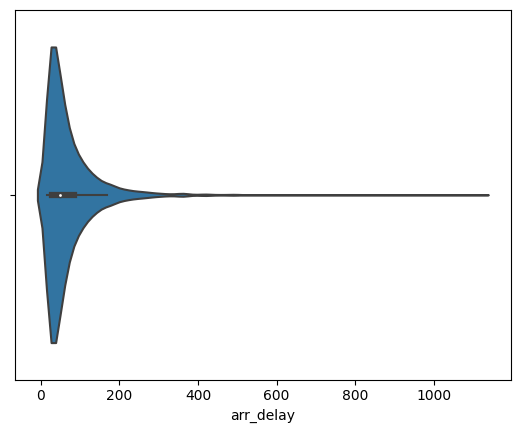

In [9]:
sns.violinplot(data=df_15, x='arr_delay', inner='box')

## Question 5: Create a DataFrame containing the ARR_DELAY and DEP_DELAY of 0.1% of all flights. Show the summary statistics of the DataFrame.

In [10]:
%%bigquery df_0001
select arr_delay, dep_delay
from dsongcp.flights_tzcorr
where rand() < 0.001

Query is running:   0%|          |

Downloading:   0%|          |

In [11]:
df_0001.describe()

,arr_delay,dep_delay
count,5641.000000,5664.000000
mean,3.840631,9.032839
std,36.151066,34.653844
min,-59.000000,-19.000000
25%,-13.000000,-5.000000
50%,-5.000000,-2.000000
75%,7.000000,7.000000
max,453.000000,629.000000


## Question 6: Add a new column 'ontime' to the DataFrame extracted in Question 5 using the following conditions. Show the summary statistics including the 'ontime' column.
- ### 'ontime' = True if the DEP_DELAY is less than 15 minutes. 
- ### Otherwise, 'ontime' = False.

In [12]:
df_0001['ontime'] = df_0001['dep_delay'] < 15

In [13]:
df_0001.head()

,arr_delay,dep_delay,ontime
0,-18.0,-10.0,True
1,-23.0,-5.0,True
2,-15.0,1.0,True
3,32.0,40.0,False
4,-14.0,4.0,True


In [14]:
df_0001.describe(include='all')

,arr_delay,dep_delay,ontime
count,5641.000000,5664.000000,5734
unique,NaN,NaN,2
top,NaN,NaN,True
freq,NaN,NaN,4646
mean,3.840631,9.032839,NaN
std,36.151066,34.653844,NaN
min,-59.000000,-19.000000,NaN
25%,-13.000000,-5.000000,NaN
50%,-5.000000,-2.000000,NaN
75%,7.000000,7.000000,NaN


## Question 7: Plot and compare the distributions of ARR_DELAY for flights with 'ontime' = True and flights with 'ontime' = False using the DataFrame in Querion 6.

<AxesSubplot:xlabel='arr_delay', ylabel='ontime'>

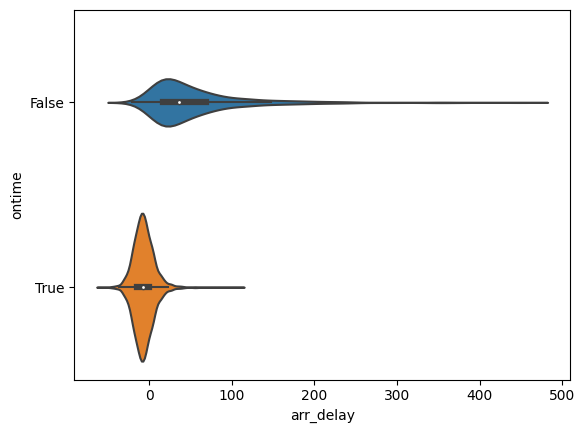

In [15]:
sns.violinplot(data=df_0001, x='arr_delay', y='ontime', inner='box', orient='h')

## Question 8: Create a DataFrame containing the average ARR_DELAY and total number of flights for each DEP_DELAY. Order the results by DEP_DELAY in ascending order. Show the head of the DataFrame.

In [16]:
%%bigquery df_avg_arr
select dep_delay, avg(arr_delay) as avg_arr_delay, count(*) as numFlights
from dsongcp.flights_tzcorr
group by dep_delay
order by dep_delay

Query is running:   0%|          |

Downloading:   0%|          |

In [17]:
df_avg_arr.head()

,dep_delay,avg_arr_delay,numFlights
0,NaN,NaN,86153
1,-82.0,-80.0,1
2,-68.0,-87.0,1
3,-61.0,-77.0,1
4,-56.0,-26.0,1


## Question 9: Same as above. Create a DataFrame by removing the records with the total number of flights fewer than 500.  Add a column corresponding to the standard deviation of the ARR_DELAY. Show the head of the DataFrame.

In [18]:
%%bigquery df_avg_arr
select dep_delay, avg(arr_delay) as avg_arr_delay, stddev(arr_delay) as std_arr_delay, count(*) as numFlights
from dsongcp.flights_tzcorr
group by dep_delay
having numFlights >= 500
order by dep_delay

Query is running:   0%|          |

Downloading:   0%|          |

In [19]:
df_avg_arr.head()

,dep_delay,avg_arr_delay,std_arr_delay,numFlights
0,NaN,NaN,NaN,86153
1,-22.0,-23.227488,12.590133,635
2,-21.0,-22.299781,11.558313,917
3,-20.0,-21.407821,12.066489,1434
4,-19.0,-20.430769,11.910134,1958


## Question 10: Plot the relations between DEP_DELAYs and the means and standard deviations of ARR_DELAYs using the DataFrame in Question 9.

<AxesSubplot:xlabel='dep_delay'>

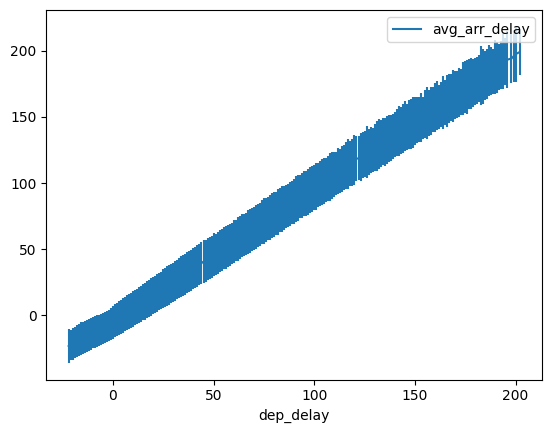

In [20]:
df_avg_arr.plot(kind='line', x='dep_delay', y='avg_arr_delay', yerr='std_arr_delay')

## Question 11 [Make Probabilistic Suggestion for Canceling a Meeting at Destination]: 
### Assume we have an important meeting at destination. We want to decide whether to postpone or cancel the meeting depending on the predicted arrival delay time. Our decision criterion is 30 minutes and 30%. That is, if the plane is more than 30% likely to be delayed (on arrival) by more than 30 minutes, we want to send a text message asking to postpone or cancel the meeting. At what departure delay does this happen? Plot the data and find the DEP_DELAY where there is a 30% chance that the ARR_DELAY is more than 30 minutes using the DataFrame in Question 9.

In [21]:
df_avg_arr[(df_avg_arr.avg_arr_delay > 28) & (df_avg_arr.avg_arr_delay < 32)]

,dep_delay,avg_arr_delay,std_arr_delay,numFlights
56,33.0,28.045747,15.031644,15294
57,34.0,29.254488,15.249758,14895
58,35.0,30.204133,15.304125,14410
59,36.0,30.971199,15.213742,13639


In [22]:
import scipy.stats as stats
z_score = stats.norm.ppf(0.7)
z_score

0.5244005127080407

In [23]:
mean = 30
std = 15

# Calculate the arr_delay value that corresponds to the 70th percentile
arr_delay_70th_percentile = mean + z_score * std

print("The arrival delay with at least 70% probability is approximately:", arr_delay_70th_percentile) 

The arrival delay with at least 70% probability is approximately: 37.86600769062061


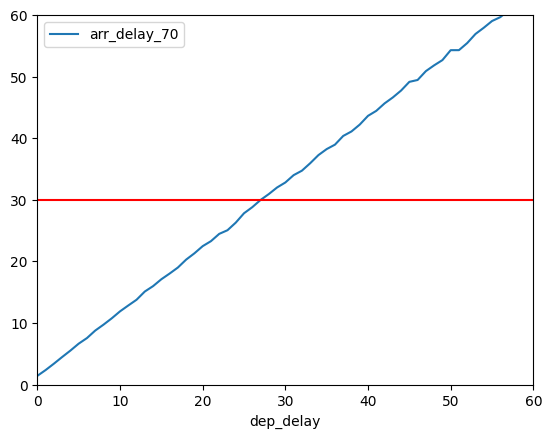

In [24]:
df_avg_arr['arr_delay_70'] = df_avg_arr['avg_arr_delay'] + df_avg_arr['std_arr_delay'] * z_score
df_avg_arr.plot(kind='line', x='dep_delay', y='arr_delay_70', ylim=(0, 60), xlim=(0, 60))
plt.axhline(y=30, color='r')

In [25]:
df_avg_arr[(df_avg_arr.arr_delay_70 > 28) & (df_avg_arr.arr_delay_70 < 32)]

,dep_delay,avg_arr_delay,std_arr_delay,numFlights,arr_delay_70
49,26.0,20.998064,14.875736,20758,28.798908
50,27.0,22.075777,15.050010,20188,29.968010
51,28.0,23.055593,15.013764,19186,30.928819
52,29.0,24.139610,14.986114,18303,31.998336
